# Tracer Test Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
path = '../scripts/'
sys.path.append(path) # append the path to module
import analysis
import visualize

## Loading Experimental Data

Data on experimental setting:

In [3]:
depth = 23 #cm
EC_back = 339.4 #uS/cm
EC_inject = 1415 #uS/cm
flow_rate = 60 #cm3/min	
t_dur = 10 # min duration of injection
diam = 10 #cm

File pathes and experimental data loading:

In [4]:
file_tracer_data = '../data/tracertest.csv'
time, tracer =  analysis.import_data(file_tracer_data)

,time,EC
0,min,uS/cm
1,1.323,331.4
2,3.323,328.7
3,5.323,333.1
4,7.323,341.7
5,9.323,396.3
6,11.323,495.1
7,13.323,679.4
8,15.323,1000
9,17.323,1208


Plot raw data for selected sample location and selected core:

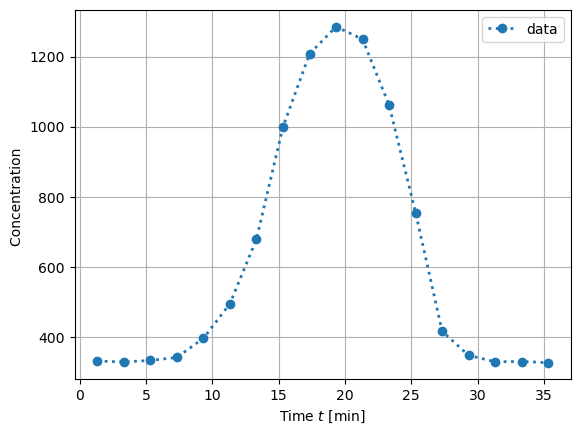

In [17]:
visualize.btc(tracer,time)
#plt.ylabel(r"Concentration $C(t) = EC$ [$\mu$S/cm]")

## Data normalization

### Procedure:
* normalize tracer data by deducing background concentration
* determine total injected mass by integration (to check if maximum concentration was observed or if tracer was diluted)
* calculate dimensionless tracer distribution by normalizing with average input concentration
* determine BTC point, i.e. location of advective front where $C = 0.5\cdot C_0$ from interpolation

**Normalize tracer data by subtract background concentration**

In [6]:
tracer_norm = analysis.normalize_data(tracer,EC_back)
#print(tracer_norm)

[  0.    0.    0.    2.3  56.9 155.7 340.  660.6 868.6 946.6 910.6 722.6
 415.3  77.    7.9   0.    0.    0. ]


**Determine average input salt concentration from integration of BTC**

In [7]:
c_av = analysis.input_concentration(tracer_norm,time,t_dur)
print("Average concentration of salt injected during the {:.2f} min of injection is C = {:.1f} uS/cm:".format(t_dur, c_av))

Average concentration of salt injected during the 10.00 min of injection is C = 1032.8 uS/cm:


In [8]:
c_max = analysis.max_concentration(tracer_norm)
print("Maximal observed values of C = {:.1f} uS/cm".format(c_max))

Maximal observed values of C = 946.6 uS/cm


**Calculate dimensionless tracer distribution by normalizing with average input concentration**

In [9]:
tracer_dimless = analysis.concentration_dimensionless(tracer_norm,time,t_dur)
#print(tracer_dimless)

Average input concentration higher than maximal observed value
Fix mass for normalization to average input concentration


**Determine BTC point, i.e. location of advective front where $C = 0.5\cdot C_0$ from interpolation**

In [10]:
t_50 = analysis.advection_front(tracer_dimless,time) 
print("Breakthrough time of advection front, i.e. t with C(t) = 0.5 * C_0 at t = {:.2f} min".format(t_50))

Breakthrough time of advection front, i.e. t with C(t) = 0.5 * C_0 at t = 14.42 min


### Visualization of results

Plotting normalized data and pure advection front

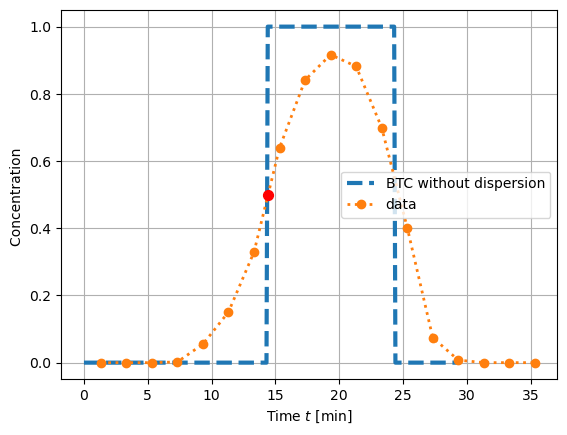

In [11]:
visualize.pure_advection(t_50,t_dur)
visualize.btc(tracer_dimless,time,t_50=t_50)
#plt.ylabel("Concentration $C(t)/C_0$ [-]")

## Calculating velocity and dispersion from data analytically

* calculate average velocity from BTC time point (i.e. $t_{50}$ with $C(t_{50}) = 0.5 \cdot C_0$)
* calculate porosity by relating average velocity and inflow rate

In [12]:
v_av = depth/t_50
print("Average velocity v = {:.2f} cm/min".format(v_av))
q_darcy = flow_rate/(np.pi*0.25*diam**2) #cm/min  # flow velocity (as if column would have full volume available)
print("Inflow velocity into column q = {:2f} cm/min".format(q_darcy))
por = q_darcy/v_av
print(r"Porosity from ratio of average velocity and inflow rate n = {:.2f}".format(por))

Average velocity v = 1.59 cm/min
Inflow velocity into column q = 0.763944 cm/min
Porosity from ratio of average velocity and inflow rate n = 0.48


### Method 1: Gradient method

Determine dispersivity from data using relationship:
      $$ \frac{\partial C}{\partial t}|_{t_{50}} = \frac{C_0 v}{2\sqrt{\pi \alpha_L x}} \quad\longrightarrow\quad 
      \alpha_L  =\left( \frac{C_0 v}{2C'(t_{50})}\right)^2 \frac{1}{\pi x} $$
      where $x$ is the observation point

**Determine the derivation at t_50, by using numerical differentiation and interpolation at t_50:**

Concentration gradient at BTC point: C'(t_50) = 0.13 1/min


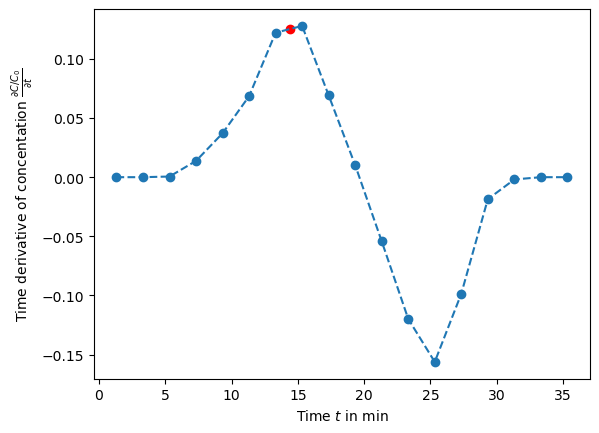

In [13]:
ct_prime = np.gradient(tracer_dimless,time)
ct_prime_50 = np.interp(t_50,time,ct_prime)
plt.plot(time,ct_prime,'o--')
plt.scatter(t_50,ct_prime_50,color = 'r')
plt.xlabel(r'Time $t$ in min')
plt.ylabel(r'Time derivative of concentation $ \frac{\partial C/C_0}{\partial t}$')
print("Concentration gradient at BTC point: C'(t_50) = {:.2f} 1/min".format(ct_prime_50)) 

In [14]:
aL = (v_av/(2*ct_prime_50))**2/(np.pi*depth)
print("Dispersivity a_L = {:.2f} cm".format(aL))

Dispersivity a_L = 0.56 cm


### Method 2: Inverting analytical solution

The analytical solution to the advection dispersion equation for this particular setting with initial and boundary conditions is given for late times with:
$$ C(x,t) = \frac{1}{2} C_0 \,\left[ \text{erfc}\left( \frac{x- v t}{\sqrt{4 D_L t}} \right) - \text{erfc}\left( \frac{x- v (t-T)}{\sqrt{4 D_L t}} \right)\right]
$$
where $\text{erfc}$ is the complementary error-function, $v$ is velocity, $D_L$ is longitudinal dispersion ($D_L = \alpha_L \cdot t$, with $\alpha$ being dispersivity), $T$ is the finite duration of the input.

For identifying dispersivity from BTC of increasing concentration branch, only first part of analytical solution of relevant. Inverting that part to determine dispersivity gives:
$$ \alpha_L =  \left( \frac{x- v t}{\text{erfc}^{-1}(2C(x,t)/C_0)} \right)^2 \frac{1}{4 v t}
$$



In [15]:
i1 = np.argmin(tracer_dimless<0.2) # determine index location close to C_50 left
i2 = np.argmin(tracer_dimless<0.8) # determine index location close to C_50 right
if i2-i1<2:
    print("Warning: not sufficient data points around BTC point with C = 0.5")
t_data = time[i1:i2+1]
ct_data = tracer_dimless[i1:i2+1]

al_range = 0.25*(depth - v_av*t_data)**2/(erfcinv(2.*ct_data))**2/(t_data*v_av)
print("Calculated dispersivities around BTC point:\n",al_range.values)
aL2 = np.mean(abs(al_range[1:]))
print("Dispersivity a_L = {:.2f} cm".format(aL2))
disp = v_av*aL2
print("Dispersion D = a_L * v = {:.2f} cm^2/s".format(disp))

NameError: name 'erfcinv' is not defined

Defining analytical solutions of ADE for specific experimental setting

In [ ]:
def constant_diffusion(arg,spread):
    """ general solution of diffusive transport in 1D for constant injection"""
    cxt = erfc(0.5*arg /np.sqrt(spread))
    return cxt     

def ade_analyticial_btc(t,x,v,t_dur = None,c0 = 1,deff = 6e-4,alpha = 1):
    """
    Analytical solution for conservative tracer transport 1D according to the Advection dispersion equation with constant 
    velocity 
        - evaluated at a given location over time (BTC)
        - for boundary conditions of a temporal constant input of tracer

    Input
    -----
        t (array-like) :  time steps [in min]
        x (float)      :  observation location [in cm]
        v (float)      :  flow velocity [in cm/min]
        t_dur (float)  :  duration of input (time when constant input stops, assuming start at t = 0)
        c0 (float)     :  input concentration (default 1  - assuming normalized concentrations)
        deff (float)   :  effective diffusion [in cm^2/min]
        alpha (float)  :  longitudinal dispersivity [in cm]
    """
    
    arg= x - v * t
    spread = (deff + v*alpha)*t
    ct = 0.5* c0 * constant_diffusion(arg,spread)

    if t_dur is not None:
        arg = np.argmin(abs(t-t_dur))
        ct2 = np.zeros_like(t)
        ct2[arg:] = ct[:-arg]

        ct  = ct - ct2
    return ct

## Plotting analytical solution data with best fit parameters vs experimental data

In [ ]:
dt = 0.5
t = np.arange(dt,36+dt,dt)# min
aL3 = 0.5*(aL+aL2)
ct = ade_analyticial_btc(t,depth,v_av,t_dur = t_dur,alpha = aL)
ct2 = ade_analyticial_btc(t,depth,v_av,t_dur = t_dur,alpha = aL2)
ct3 = ade_analyticial_btc(t,depth,v_av,t_dur = t_dur,alpha = aL3)

# aL4 = 0.2
# ct4 = ade_analyticial_btc(t,x_loc1,v_av,t_dur = t_dur,alpha = aL4)

plt.figure(figsize = [12,5])
plt.plot(t,ct,label='aL = {:.2f}cm'.format(aL))
plt.plot(t,ct3,label='aL = {:.2f}cm'.format(aL3))
plt.plot(t,ct2,label='aL = {:.2f}cm'.format(aL2))
#plt.plot(t,ct4,label='aL = {:.2f}cm'.format(aL4))
plt.plot(time,tracer_dimless,'o',lw = 2,label = 'data')
plt.scatter(t_50,0.5,c = 'k',s = 50,zorder = 5)
plt.grid(True)
plt.legend()
plt.xlabel("Time $t$ [min]")
plt.ylabel("Normalized Concentration $C(t)/C_0$ [-]")

